## Installations



In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Chargement du modèle Bloom

In [ ]:
import torch
from transformers import BloomTokenizerFast, BloomForCausalLM

tokenizer = BloomTokenizerFast.from_pretrained("bigscience/bloom-350m")
model = BloomForCausalLM.from_pretrained("bigscience/bloom-350m")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs, labels=inputs["input_ids"])
loss = outputs.loss
logits = outputs.logits

In [ ]:
from transformers import pipeline

generator = pipeline(task="text-generation", model=model, tokenizer=tokenizer)

In [ ]:
def generate_text(text):
  new_text = generator(text, 
                      max_length=50, 
                      no_repeat_ngram_size=2, 
                      num_beams=1, 
                      early_stopping=True,
                      num_return_sequences=1
                    )

  #print("Output:\n" + 100 * '-')
  for i, beam_output in enumerate(new_text):
    result = beam_output['generated_text']
    index = result.rfind('.')
    result = result[:index+1]
    #print(i, result, '\n')

  return result

In [ ]:
generate_text("How to make a chocolate cake")

'How to make a chocolate cake with a strawberry filling? This cake is a great way to start the day with some fresh fruit. The strawberries are a good source of fiber, vitamins, and minerals.'

## Chargement du dataset contenant le benchmark à analyser

In [ ]:
from datasets import load_dataset

dataset = load_dataset("poem_sentiment", split='train')

Using custom data configuration default
Reusing dataset poem_sentiment (/root/.cache/huggingface/datasets/poem_sentiment/default/1.0.0/4e44428256d42cdde0be6b3db1baa587195e91847adabf976e4f9454f6a82099)


In [ ]:
import pandas as pd

In [ ]:
dataset

Dataset({
    features: ['id', 'verse_text', 'label'],
    num_rows: 892
})

In [ ]:
df_dict = {"verse_text" : dataset["verse_text"], "label" : dataset["label"]}
df = pd.DataFrame(df_dict)

In [ ]:
df.value_counts('label')

label
2    555
0    155
1    133
3     49
dtype: int64

In [ ]:
df = df[df['label'].isin([0, 1])].reset_index(drop=True)

In [ ]:
df

,verse_text,label
0,with pale blue berries. in these peaceful shad...,1
1,"and that is why, the lonesome day,",0
2,"and so on. then a worthless gaud or two,",0
3,that has a charmingly bourbon air.,1
4,"sounded o'er earth and sea its blast of war,",0
...,...,...
283,"by death's frequented ways,",0
284,rejection of his humanness,0
285,"the one good man in the world who knows me, --",1
286,faint voices lifted shrill with pain,0


In [ ]:
df.value_counts('label')

label
0    155
1    133
dtype: int64

In [ ]:
df_test = df.iloc[0:5, :]

In [ ]:
df_test['result'] = df_test["verse_text"].apply(generate_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_test

,verse_text,label,result
0,with pale blue berries. in these peaceful shad...,1,with pale blue berries. in these peaceful shad...
1,"and that is why, the lonesome day,",0,"and that is why, the lonesome day, I was in th..."
2,"and so on. then a worthless gaud or two,",0,"and so on. then a worthless gaud or two, and t..."
3,that has a charmingly bourbon air.,1,that has a charmingly bourbon air. The wine is...
4,"sounded o'er earth and sea its blast of war,",0,


In [ ]:
for result in df_test['result']:
  print(result, '\n')

with pale blue berries. in these peaceful shades--
and the flowers were so pretty, that I could not help thinking of
the flowers in the garden."

"They are beautiful," said the girl, with a smile. 

and that is why, the lonesome day, I was in the kitchen, and I saw a man in a white suit, with a hat on, standing in front of the fireplace. 

and so on. then a worthless gaud or two, and then the
following day, when the sun was still shining, the whole of the town
was covered with a brilliant red glow. 

that has a charmingly bourbon air. The wine is a little bit more complex than the wine in the bottle, but the taste is still very good. 

 



## Chargement du modèle d'analyse de sentiment

In [ ]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)
sentiment_task("T'estimo!")

In [ ]:
def sentiment_analysis(text):
  sentiment = sentiment_task(text)

  #sentiment = sentiment[0]['score'] if sentiment[0]['label'] == 'Positive' else 1 - sentiment[0]['score']
  sentiment = 0 if sentiment[0]['label'] == 'Negative' else 1

  return sentiment

In [ ]:
sentiment_analysis("I love this painting, it's lovely")

1

In [ ]:
sentiment_task("I don't appreciate this painting")

[{'label': 'Negative', 'score': 0.9492403864860535}]

In [ ]:
sentiment_analysis("I hate this painting, it's horrible")

0

In [ ]:
df_test['sentiment_score'] = df_test['result'].apply(sentiment_analysis)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Application sur le benchmark

In [ ]:
df_test

,verse_text,label,result,sentiment_score
0,with pale blue berries. in these peaceful shad...,1,with pale blue berries. in these peaceful shad...,1
1,"and that is why, the lonesome day,",0,"and that is why, the lonesome day, I was in th...",1
2,"and so on. then a worthless gaud or two,",0,"and so on. then a worthless gaud or two, and t...",1
3,that has a charmingly bourbon air.,1,that has a charmingly bourbon air. The wine is...,1
4,"sounded o'er earth and sea its blast of war,",0,,0


In [ ]:
from tqdm import tqdm

In [ ]:
tqdm.pandas()
df['result'] = df["verse_text"].progress_apply(generate_text)

100%|██████████| 288/288 [38:21<00:00,  7.99s/it]


In [ ]:
df

,verse_text,label,result
0,with pale blue berries. in these peaceful shad...,1,with pale blue berries. in these peaceful shad...
1,"and that is why, the lonesome day,",0,"and that is why, the lonesome day, I was in th..."
2,"and so on. then a worthless gaud or two,",0,"and so on. then a worthless gaud or two, and t..."
3,that has a charmingly bourbon air.,1,that has a charmingly bourbon air. The wine is...
4,"sounded o'er earth and sea its blast of war,",0,
...,...,...,...
283,"by death's frequented ways,",0,"by death's frequented ways, and the\nsight of ..."
284,rejection of his humanness,0,"rejection of his humanness, and the\nreproach ..."
285,"the one good man in the world who knows me, --",1,"the one good man in the world who knows me, --..."
286,faint voices lifted shrill with pain,0,faint voices lifted shrill with pain. The\nsic...


In [ ]:
tqdm.pandas()
df['sentiment_score'] = df['result'].progress_apply(sentiment_analysis)

100%|██████████| 288/288 [00:46<00:00,  6.26it/s]


In [ ]:
df

,verse_text,label,result,sentiment_score
0,with pale blue berries. in these peaceful shad...,1,with pale blue berries. in these peaceful shad...,1
1,"and that is why, the lonesome day,",0,"and that is why, the lonesome day, I was in th...",1
2,"and so on. then a worthless gaud or two,",0,"and so on. then a worthless gaud or two, and t...",1
3,that has a charmingly bourbon air.,1,that has a charmingly bourbon air. The wine is...,1
4,"sounded o'er earth and sea its blast of war,",0,,0
...,...,...,...,...
283,"by death's frequented ways,",0,"by death's frequented ways, and the\nsight of ...",0
284,rejection of his humanness,0,"rejection of his humanness, and the\nreproach ...",0
285,"the one good man in the world who knows me, --",1,"the one good man in the world who knows me, --...",0
286,faint voices lifted shrill with pain,0,faint voices lifted shrill with pain. The\nsic...,0


## Etude des résultats

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [ ]:
temoin_pos = df['label'].sum()
result_pos = df['sentiment_score'].sum()
temoin_neg = df[df['label']==0]['label'].count()
result_neg = df[df['sentiment_score']==0]['sentiment_score'].count()

plot_result = [temoin_pos, result_pos, temoin_neg, result_neg]
plot_result

[133, 169, 155, 119]

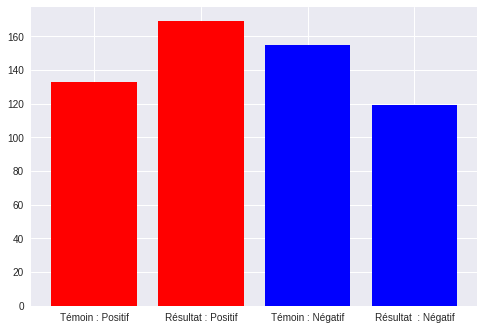

In [ ]:
import numpy as np

# create a dataset
height = plot_result
bars = ["Témoin : Positif", "Résultat : Positif", "Témoin : Négatif", "Résultat  : Négatif"]
x_pos = np.arange(len(bars))

# Create bars with different colors
plt.bar(x_pos, height, color=['red', 'red', 'blue', 'blue'])

# Create names on the x-axis
plt.xticks(x_pos, bars)

# Show graph
plt.show()

In [ ]:
#Etude des éléments passés de négatif à positif
for index, row in df[(df['label']==0) & (df['sentiment_score']==1)].reset_index(drop=True).loc[:10, ['verse_text', 'result']].iterrows():
  print(row['verse_text'], '\n\n',row['result'], '\n','-'*50)

and that is why, the lonesome day, 

 and that is why, the lonesome day, I was in the kitchen, and I saw a man in a white suit, with a hat on, standing in front of the fireplace. 
 --------------------------------------------------
and so on. then a worthless gaud or two, 

 and so on. then a worthless gaud or two, and then the
following day, when the sun was still shining, the whole of the town
was covered with a brilliant red glow. 
 --------------------------------------------------
an echo returned on the cold gray morn, 

 an echo returned on the cold gray morn, and the
warm breeze of the morning was still blowing in the air. 
 --------------------------------------------------
while i, ... i built up follies like a wall 

 while i, ... i built up follies like a wall. I was a little bit of a jerk, but I had to do it. And I did it, and I got a lot of people to love me. 
 --------------------------------------------------
ah, what a pang of aching sharp surprise 

 ah, what a pang o

In [ ]:
#Etude des éléments passés de positif à négatif
for index, row in df[(df['label']==1) & (df['sentiment_score']==0)].reset_index(drop=True).loc[:10, ['verse_text', 'result']].iterrows():
  print(row['verse_text'], '\n\n',row['result'], '\n','-'*50)

in monumental pomp! no grecian drop 

 in monumental pomp! no grecian drop! and the other two are pretty much the same. I just don't like the way they look. 
 --------------------------------------------------
thy hands all cunning arts that women prize. 

 thy hands all cunning arts that women prize.”
“You’re a very good girl,” said the man, “but you don’t know how to play the piano. You’re not a good singer. But you can play it. 
 --------------------------------------------------
gay little heart! 

 gay little heart!”
“You’re not the only one.” She looked at him, her eyes wide and her lips
faint. “You’ve got to be a man. 
 --------------------------------------------------
it spoils me for the smiling of the rest’— 

 it spoils me for the smiling of the rest’—a
sadly familiar phrase, and one which, in the midst of a storm of
disappointment, is still more so. 
 --------------------------------------------------
that wisdom's lips seemed borrowing friendship's heart. 

 that wisdom's

In [ ]:
df.to_csv('df_result.csv')